# Metric learning MNIST embeddings comparison

- All models uses ResNet18 as base model, or as it is.
- Using fast.ai library on pytorch.

### Tools: Basic utilities

In [1]:
from fastai.vision import *
from torchvision import datasets, transforms
from torch import nn
import PIL
from tqdm import tqdm
from dlcliche.image import *


def prepare_full_MNIST_databunch(data_folder, tfms):
    """
    Prepare dataset as images under:
        data_folder/images/('train' or 'valid')/(class)
    where filenames are:
        img(class)_(count index).png
    """
    train_ds = datasets.MNIST(data_folder, train=True, download=True,
                          transform=transforms.Compose([
                              transforms.Normalize((0.1307,), (0.3081,))
                          ]))
    valid_ds = datasets.MNIST(data_folder, train=False,
                              transform=transforms.Compose([
                                  transforms.Normalize((0.1307,), (0.3081,))
                              ]))

    def have_already_been_done():
        return (data_folder/'images').is_dir()
    def build_images_folder(data_root, X, labels, dest_folder):
        images = data_folder/'images'
        for i, (x, y) in tqdm.tqdm(enumerate(zip(X, labels))):
            folder = images/dest_folder/f'{y}'
            ensure_folder(folder)
            x = x.numpy()
            image = np.stack([x for ch in range(3)], axis=-1)
            PIL.Image.fromarray(image).save(folder/f'img{y}_{i:06d}.png')

    if not have_already_been_done():
        build_images_folder(data_root=DATA, X=train_ds.train_data,
                            labels=train_ds.train_labels, dest_folder='train')
        build_images_folder(data_root=DATA, X=valid_ds.test_data, 
                            labels=valid_ds.test_labels, dest_folder='valid')

    return ImageDataBunch.from_folder(DATA/'images', ds_tfms=tfms)


def get_embeddings(embedding_model, data_loader, label_catcher=None):
    """
    Calculate embeddings for all samples in a data_loader.
    
    Args:
        label_catcher: LearnerCallback for keeping last batch labels.
    """
    embs = []
    for X, y in data_loader:
        # For each batch (X, y),
        #   Set labels (y) if label_catcher's there.
        if label_catcher:
            label_catcher.on_batch_begin(X, y, train=False)
        #   Get embeddings for this batch, store in embs.
        with torch.no_grad():
            # Note that model's output is not softmax'ed.
            out = embedding_model(X).cpu().detach().numpy()
            out = out.reshape((len(out), -1))
            embs.append(out)
    # Putting all embeddings in shape (number of samples, length of one sample embeddings)
    embs = np.concatenate(embs) # Maybe in (10000, 10)
    return embs

### Tools: Visualizers

In [2]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import axes3d
#%matplotlib notebook


def show_2D_tSNE(latent_vecs, target, title='t-SNE viz'):
    latent_vecs = latent_vecs
    latent_vecs_reduced = TSNE(n_components=2, random_state=0).fit_transform(latent_vecs)
    plt.scatter(latent_vecs_reduced[:, 0], latent_vecs_reduced[:, 1],
                c=target, cmap='jet')
    plt.colorbar()
    plt.show()


def show_3D_tSNE(latent_vecs, target, title='3D t-SNE viz'):
    latent_vecs = latent_vecs
    tsne = TSNE(n_components=3, random_state=0).fit_transform(latent_vecs)
    fig = plt.figure(figsize=(13,10))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter3D(tsne[:, 0], tsne[:, 1], tsne[:, 2], c=target, cmap='jet')
    ax.set_title(title)
    plt.colorbar(scatter)
    plt.show()


def show_as_PCA(latent_vecs, target, title='PCA viz'):
    latent_vecs = latent_vecs
    #latent_vecs_reduced = TSNE(n_components=2, random_state=0).fit_transform(latent_vecs)
    latent_vecs_reduced = PCA(n_components=2).fit_transform(latent_vecs)
    plt.scatter(latent_vecs_reduced[:, 0], latent_vecs_reduced[:, 1],
                c=target, cmap='jet')
    plt.colorbar()
    plt.show()

## Preparing Data

Putting all data as 3-channel images in _standard_ classifier data structure.

    i.e. (root)/(train or valid)/(label)/(image files)


In [3]:
DATA = Path('data')
data = prepare_full_MNIST_databunch(DATA, get_transforms(do_flip=False))

## 0. Raw data distribution

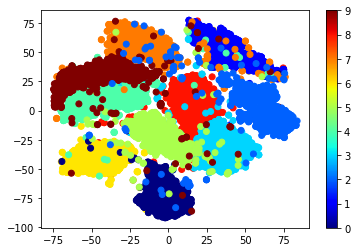

In [4]:
raw_x = np.array([a.data.numpy() for a in data.valid_ds.x])
raw_y = np.array([int(y.obj) for y in data.valid_ds.y])
raw_x = raw_x.reshape((len(raw_x), -1))

if False: # for saving time
    LIMIT = 1000
    chosen_idxes = np.random.choice(list(range(len(raw_x))), LIMIT)
    raw_x = raw_x[chosen_idxes]
    raw_y = raw_y[chosen_idxes]

show_2D_tSNE(raw_x, raw_y, 'Raw sample distributions (t-SNE)')

## 1. Conventional softmax model

epoch,train_loss,valid_loss,accuracy,time
0,0.395519,0.244444,0.922500,00:16


epoch,train_loss,valid_loss,accuracy,time
0,0.101246,0.035705,0.990500,00:20
1,0.057852,0.049028,0.986000,00:18
2,0.055760,0.033056,0.990600,00:18


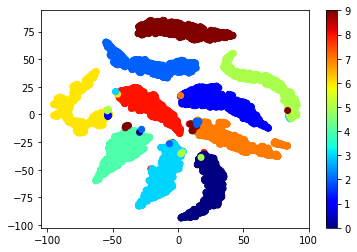

In [5]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)

learn.fit(1)
learn.unfreeze()
learn.fit(3)

embs = get_embeddings(learn.model, data.valid_dl)
show_2D_tSNE(embs, [int(y) for y in data.valid_ds.y], title='Simply trained ResNet18 (t-SNE)')

## L2-constrained Softmax Loss

- R. Ranjan, C. D. Castillo, and R. Chellappa. L2-constrained softmax loss for discriminative face verification. arXiv preprint arXiv:1703.09507, 2017. https://arxiv.org/pdf/1703.09507.pdf

epoch,train_loss,valid_loss,accuracy,time
0,0.983822,0.883194,0.940700,00:16


epoch,train_loss,valid_loss,accuracy,time
0,0.809431,0.760116,0.987400,00:20
1,0.795656,0.761034,0.986700,00:20
2,0.793012,0.749369,0.993000,00:18
3,0.785471,0.752946,0.991200,00:19
4,0.781374,0.753102,0.991300,00:20


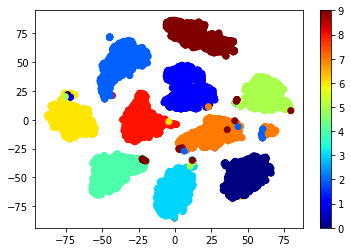

In [6]:
class L2ConstraintedNet(nn.Module):
    def __init__(self, org_model, alpha=16, num_classes=1000):
        super().__init__()
        self.model = org_model
        self.alpha = alpha

    def forward(self, x):
        x = self.model(x)
        
        l2 = torch.sqrt((x**2).sum())
        x = self.alpha * (x / l2)
        return x

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.model = L2ConstraintedNet(learn.model)

learn.fit(1)
learn.unfreeze()
learn.fit(5)

embs = get_embeddings(learn.model, data.valid_dl)
show_2D_tSNE(embs, [int(y) for y in data.valid_ds.y], title='L2 constrainted ResNet18 (t-SNE)')

## 2. ArcFace

- J. Deng, J. Guo, and S. Zafeiriou. Arcface: Additive angular margin loss for deep face recognition. arXiv preprint arXiv:1801.07698, 2018. https://arxiv.org/pdf/1801.07698.pdf
- Pytorch implementation: https://github.com/ronghuaiyang/arcface-pytorch

In [7]:
try:
    from metrics import *
except:
    ! wget https://raw.githubusercontent.com/ronghuaiyang/arcface-pytorch/master/models/metrics.py
    from metrics import *

epoch,train_loss,valid_loss,accuracy,time
0,4.176539,2.766515,0.804800,00:17


epoch,train_loss,valid_loss,accuracy,time
0,1.008353,0.371713,0.984300,00:22
1,0.877257,0.482216,0.980100,00:23
2,0.649511,0.322249,0.984600,00:23
3,0.482227,0.375752,0.982100,00:23
4,0.449403,0.210597,0.990200,00:21


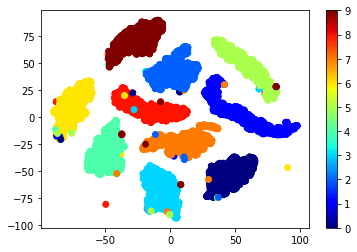

In [8]:
class LabelCatcher(LearnerCallback):
    last_labels = None

    def __init__(self, learn:Learner):
        super().__init__(learn)
        
    def on_batch_begin(self, last_input, last_target, train, **kwargs):
        LabelCatcher.last_labels = last_target
        return {'last_input': last_input, 'last_target': last_target} 

class XFaceNet(nn.Module):
    def __init__(self, org_model, xface_product=ArcMarginProduct, m=0.5):
        super().__init__()
        self.org_model = org_model
        self.metric_fc = xface_product(10, 10, m=m).cuda()
    
    def forward(self, x):
        x = self.org_model(x)
        x = self.metric_fc(x, LabelCatcher.last_labels)
        return x

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.model = XFaceNet(learn.model, ArcMarginProduct, m=0.5)
learn.callback_fns.append(partial(LabelCatcher))
learn.fit(1)
learn.unfreeze()
learn.fit(5)

embs = get_embeddings(learn.model, data.valid_dl, LabelCatcher(learn))
show_2D_tSNE(embs, [int(y) for y in data.valid_ds.y], title='ArcFace (t-SNE)')

In [9]:
#show_3D_tSNE(embs, [int(y) for y in data.valid_ds.y])

## 3. CosFace
- H. Wang, Y. Wang, Z. Zhou, X. Ji, D. Gong, J. Zhou, Z. Li, and W. Liu, CosFace: Large Margin Cosine Loss for Deep Face Recognition, arXiv preprint arXiv:1801.09414, 2018. https://arxiv.org/pdf/1801.09414.pdf
- Pytorch implementation: https://github.com/ronghuaiyang/arcface-pytorch

epoch,train_loss,valid_loss,accuracy,time
0,3.545351,2.399932,0.792400,00:17


epoch,train_loss,valid_loss,accuracy,time
0,0.848682,0.563751,0.969900,00:21
1,0.662691,0.358378,0.981500,00:22
2,0.541272,0.304942,0.984000,00:19
3,0.386531,0.234737,0.988000,00:21
4,0.397352,0.225195,0.988100,00:20


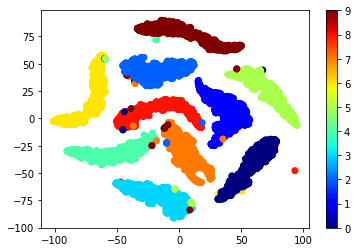

In [10]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.model = XFaceNet(learn.model, AddMarginProduct, m=0.4)
learn.callback_fns.append(partial(LabelCatcher))
learn.fit(1)
learn.unfreeze()
learn.fit(5)

embs = get_embeddings(learn.model, data.valid_dl, LabelCatcher(learn))
show_2D_tSNE(embs, [int(y) for y in data.valid_ds.y], title='SphereFace (t-SNE)')

## 4. SphereFace

- W. Liu, Y. Wen, Z. Yu, M. Li, B. Raj, and L. Song. SphereFace: Deep Hypersphere Embedding for Face Recognition. In CVPR, 2017. https://arxiv.org/pdf/1704.08063.pdf
- Pytorch implementation: https://github.com/ronghuaiyang/arcface-pytorch

epoch,train_loss,valid_loss,accuracy,time
0,0.682756,0.442762,0.885700,00:19


epoch,train_loss,valid_loss,accuracy,time
0,0.178191,0.086582,0.986600,00:23
1,0.139368,0.070142,0.988200,00:22
2,0.116614,0.046260,0.991800,00:22
3,0.092168,0.059089,0.989800,00:21
4,0.121175,0.044285,0.992900,00:21


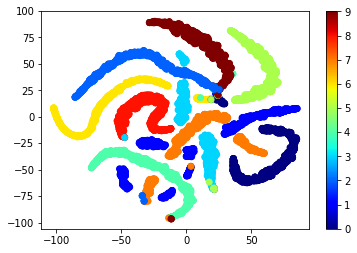

In [11]:
learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.model = XFaceNet(learn.model, SphereProduct, m=int(4))
learn.callback_fns.append(partial(LabelCatcher))
learn.fit(1)
learn.unfreeze()
learn.fit(5)

embs = get_embeddings(learn.model, data.valid_dl, LabelCatcher(learn))
show_2D_tSNE(embs, [int(y) for y in data.valid_ds.y], title='SphereFace (t-SNE)')

## 5. Center Loss

- Y. Wen, K. Zhang, Z. Li, and Y. Qiao, A discriminative feature learning approach for deep face recognition,” in European Conference on Computer Vision. Springer, 2016, pp. 499–515. https://ydwen.github.io/papers/WenECCV16.pdf
- Pytorch implementation: https://github.com/KaiyangZhou/pytorch-center-loss

In [12]:
try:
    from center_loss import *
except:
    ! wget https://raw.githubusercontent.com/KaiyangZhou/pytorch-center-loss/master/center_loss.py
    from center_loss import *

epoch,train_loss,valid_loss,accuracy,time
0,2.077532,1.904115,0.873400,00:17


epoch,train_loss,valid_loss,accuracy,time
0,1.722963,1.593077,0.986000,00:21
1,1.685262,1.585221,0.989800,00:21
2,1.674736,1.595060,0.989900,00:21
3,1.651739,1.577048,0.992500,00:21
4,1.636412,1.573784,0.992100,00:21


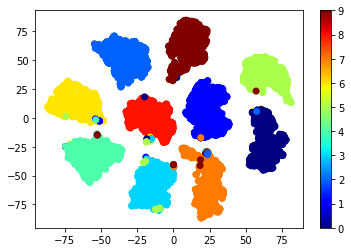

In [13]:
class WrapCenterLoss(nn.Module):
    "Adapt the loss function `crit` to go with MixMatch."
    
    def __init__(self, learn, weight_cent=1/10):
        super().__init__()
        self.org_loss = learn.loss_func
        self.center_loss = CenterLoss(10, 10)
        self.weight_cent = weight_cent

    def forward(self, output, target):
        dL = self.org_loss(output, target)
        dC = self.center_loss(output, target)
        #print(dL, dC)
        d = dL + self.weight_cent * dC
        return d

learn = cnn_learner(data, models.resnet18, metrics=accuracy)
learn.loss_func = WrapCenterLoss(learn, weight_cent=1/8) ## Hand tuned

learn.fit(1)
learn.unfreeze()
learn.fit(5)

embs = get_embeddings(learn.model, data.valid_dl, LabelCatcher(learn))
show_2D_tSNE(embs, [int(y) for y in data.valid_ds.y], title='CenterLoss (t-SNE)')